In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device for Train : {device}")

Device for Train : cpu


In [4]:
import os

In [5]:
os.listdir('./')

['.ipynb_checkpoints', '2. 연락처모델_학습(0130).ipynb', '연락처학습데이터(0201).csv']

In [6]:
data = pd.read_csv('./연락처학습데이터(0201).csv')
data

,conts,label
0,"자기소개도 좋은데, 대화를 하고싶어도 하기위해서 비용이 계속 드는 거 같아요!! ""...",1
1,01058341164 연락처입니다 김효수라 하구요 마음이 따뜻해 지고 싶어요,1
2,010 9839 5444. 카톡 아이디 ibrokhim1122.,1
3,"대전에서 근무하는 35살 초등교사입니다. 자가, 자차 보유 중이고 부모님 노후 준비...",1
4,외모상관없이 착하고 착한분 원합니다 가까우신분 연락주세요 77774332,1
...,...,...
54771,어머니 전업주부 기독교 온화한 성격에 49년소띠 대구여고 본은 김녕김씨,0
54772,두분모님께서는돌아가셨고 식구가많아요 4낭5녀중5벉째입니다,0
54773,사무직을 일하고 ㅣㅆ습니다.윙0 1명은 경영 핟면ㅇ은 교사로 일하고 있어요.,0
54774,1남2녕 어머랑 따로 살고있어 각자 타지 산산ㆍ,0


In [7]:
data = data.loc[~data['conts'].isnull()]

In [8]:
data['label'].value_counts()

0    30519
1    24257
Name: label, dtype: int64

In [9]:
data.shape

(54776, 2)

In [10]:
call_df = data.copy()



In [11]:
call_df = call_df.drop_duplicates()

In [12]:
call_df.isnull().sum()

conts    0
label    0
dtype: int64

In [13]:
call_df.reset_index(drop=True, inplace=True)

In [14]:
label_0 = call_df.loc[call_df['label']==0]
label_1 = call_df.loc[call_df['label']==1]

print(label_0.shape, label_1.shape)

final_call_df = pd.concat([label_0, label_1]).reset_index(drop=True)

(30475, 2) (24239, 2)


In [15]:
# 학습 데이터 : 검증 데이터 8:2

train_data = final_call_df.sample(frac=0.8, random_state=2022)[['conts','label']]
test_data = final_call_df.drop(train_data.index)[['conts','label']]

print(train_data.shape, test_data.shape)

(43771, 2) (10943, 2)


In [16]:
model_name = 'beomi/KcELECTRA-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [17]:
# train dataset 토크나이징
tokenized_train_sentence = tokenizer(
    list(train_data['conts']),
    max_length=128,
    return_tensors='pt',  #pyotorch의 tensor 형태로 return
    padding=True,        #제로패딩 설정
    truncation=True,     # max_length 초과 토큰 truncate
    add_special_tokens=True)  # spcial token 추가


print(tokenized_train_sentence[0])
print(tokenized_train_sentence[0].tokens)
print(tokenized_train_sentence[0].ids)
print(tokenized_train_sentence[0].attention_mask)

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '혼자', '##여도', '좋지만', '삶을', '나눌', '누군가', '##가', '있다면', '좀', '더', '행복', '##에', '가까워', '##지지', '않을까', '##하는', '생각이', '드는', '요즘', '##이네요', '.', '곁', '##에', '있으', '##므로', '평온', '##하고', '삶이', '더', '채워진', '##다고', '느껴', '##지는', '분이', '##라면', '가능', '##할', '것', '같아요', '.', '친구', '##같은', '분이', '##길', '바라', '##며', '최대', '4', '##살', '연상', '##까지만', '연락', '##주세요', '.', '(', '인증', '##하신', '##분', '##만', ')', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

In [18]:
# test dataset 토크나이징
tokenized_test_sentence = tokenizer(
    list(test_data['conts']),
    max_length=128,
    return_tensors='pt',
    padding=True,
    truncation=True,
    add_special_tokens=True)

In [19]:
print(tokenized_test_sentence[0])
print(tokenized_test_sentence[0].tokens)
print(tokenized_test_sentence[0].ids)
print(tokenized_test_sentence[0].attention_mask)

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '.', '3년', '##전', '중학교', '(', '교장', ')', '에서', '정년', '##퇴직', '##하였', '##습니다', '>', '>', '사범', '##대', '##와', '사범', '##대', '교육', '##대학', '##원', '(', '교육학', '##석', '##사', ')', '.', '몸', '건강', '##하며', '일상생활', '(', '텃밭', '##채', '##소', ')', '을', '시작', '##했습니다', '.', '고향', '##이', '서울', '##토', '##박이', '##입니다', '.', '14', '.', '5', '##×', '##4', '.', '2', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',

In [20]:
class CustomDataset(torch.utils.data.Dataset) :
    def __init__(self, encodings, labels) :
        self.encodings = encodings
        self.labels = labels
        
    def __len__(self) :
        return len(self.labels)    
        
    def __getitem__(self, idx) :
        item = {key : torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [21]:
# dataset 형성(텐서로 변환)
train_label = train_data['label'].values
test_label = test_data['label'].values

train_dataset = CustomDataset(tokenized_train_sentence, train_label)
test_dataset = CustomDataset(tokenized_test_sentence, test_label)

In [22]:
# # 사전학습 모델 로드
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.weight', 'classifier.

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(50135, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [23]:
# # train option setting
train_arguments = TrainingArguments(
                     output_dir='./',
                     num_train_epochs=5,
                    per_device_train_batch_size=64,
                    per_device_eval_batch_size=64,
                    logging_dir='./logs',
                    logging_steps=500,
                    save_total_limit=2)

In [24]:
# metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, precision_score, recall_score


def compute_metrics(pred) :
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    precision = precision_score(labels, preds) 
    recall = recall_score(labels, preds)
    f1 = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy' : acc,
        'f1' : f1,
        'precision' : precision,
        'recall' : recall
    }

In [25]:
%%time

# Train
train = Trainer(
                model=model,
                args=train_arguments,
                train_dataset=train_dataset,
                eval_dataset=test_dataset,
                compute_metrics=compute_metrics)

train.train()

***** Running training *****
  Num examples = 43771
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 3420
  Number of trainable parameters = 124546562


Step,Training Loss
500,0.068400
1000,0.026200
1500,0.018200
2000,0.010200
2500,0.006400
3000,0.005600


Saving model checkpoint to ./checkpoint-500
Configuration saved in ./checkpoint-500\config.json
Model weights saved in ./checkpoint-500\pytorch_model.bin
Saving model checkpoint to ./checkpoint-1000
Configuration saved in ./checkpoint-1000\config.json
Model weights saved in ./checkpoint-1000\pytorch_model.bin
Saving model checkpoint to ./checkpoint-1500
Configuration saved in ./checkpoint-1500\config.json
Model weights saved in ./checkpoint-1500\pytorch_model.bin
Deleting older checkpoint [checkpoint-500] due to args.save_total_limit
Saving model checkpoint to ./checkpoint-2000
Configuration saved in ./checkpoint-2000\config.json
Model weights saved in ./checkpoint-2000\pytorch_model.bin
Deleting older checkpoint [checkpoint-1000] due to args.save_total_limit
Saving model checkpoint to ./checkpoint-2500
Configuration saved in ./checkpoint-2500\config.json
Model weights saved in ./checkpoint-2500\pytorch_model.bin
Deleting older checkpoint [checkpoint-1500] due to args.save_total_limit


Wall time: 16h 13min 21s


TrainOutput(global_step=3420, training_loss=0.02014127976713125, metrics={'train_runtime': 58401.4764, 'train_samples_per_second': 3.747, 'train_steps_per_second': 0.059, 'total_flos': 1.43957925052032e+16, 'train_loss': 0.02014127976713125, 'epoch': 5.0})

In [26]:
train.evaluate(eval_dataset=test_dataset)

***** Running Evaluation *****
  Num examples = 10943
  Batch size = 64


Trainer is attempting to log a value of "(0.9929911358482787, 0.9942208462332301, 0.9936056105610561, None)" of type <class 'tuple'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.03489580750465393,
 'eval_accuracy': 0.9943342776203966,
 'eval_f1': (0.9929911358482787, 0.9942208462332301, 0.9936056105610561, None),
 'eval_precision': 0.9929911358482787,
 'eval_recall': 0.9942208462332301,
 'eval_runtime': 1045.706,
 'eval_samples_per_second': 10.465,
 'eval_steps_per_second': 0.164,
 'epoch': 5.0}

        {'eval_loss': 0.039978399872779846,
         'eval_accuracy': 0.9935406477807511,
         'eval_f1': (0.9929299230609274, 0.992517148202037, 0.9927234927234927, None),
         'eval_precision': 0.9929299230609274,
         'eval_recall': 0.992517148202037,
         'eval_runtime': 1026.504,
         'eval_samples_per_second': 10.557,
         'eval_steps_per_second': 0.166,
         'epoch': 5.0}

`최종`

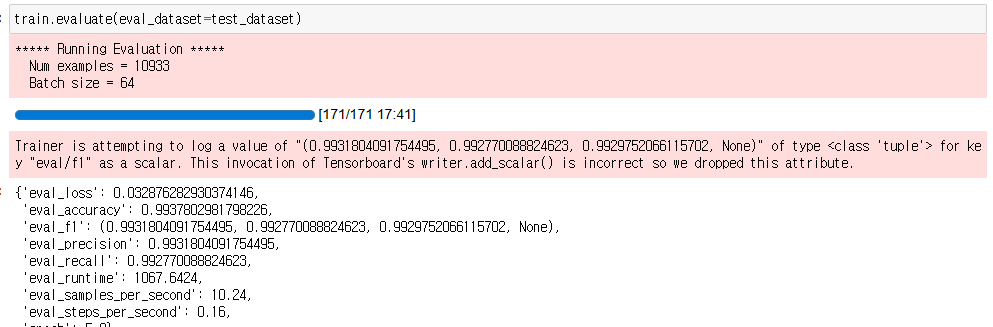

In [27]:
from datetime import datetime

today = str(datetime.today())[:10]
path = f"{today}_call_model.pt"

# save model 
torch.save(model, path)

In [28]:
from datetime import datetime

today = str(datetime.today())[:10]
path = f"{today}_call_model.pt"

# save model 
torch.save(model, path)

In [29]:
# load model
mod = torch.load(f"{today}_call_model.pt")
mod.eval()

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(50135, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [30]:
import re

class Preprocessing():

    def __init__(self, sent):
        self.sent = sent

    def clean_sentence(self):
        try:  # 무성의
            self.sent = re.sub('[^\w\s]', ' ', self.sent).strip()
            self.sent = re.sub('[.,?!ᆢ~]', ', ', self.sent)
            self.sent = re.sub('[ㄱ-ㅎ|ㅏ-ㅣ]', 'ㅋ', self.sent)
            self.sent = re.sub('니다', '니다. ', self.sent)
            self.sent = re.sub('어요', '어요. ', self.sent)
            self.sent = re.sub('\n', ' ', self.sent).strip()

        except:
            print('clean_sentence method fail')
            pass

        return self.sent

    def f_clean_sentence(self):
        try:
            self.sent = re.sub('[^\w\s]', ' ', self.sent).strip()
            self.sent = re.sub('[.,?!ᆢ~]', ', ', self.sent)
            self.sent = self.return_text(self.sent)

        except:
            print('f_clean_sentence method fail')
            pass
        return self.sent

    def sub_num(self, sent):
        hannum_list = ['일', '이', '삼', '사', '오', '육', '륙', '칠', '팔', '구', '십', '영']
        sent = re.sub(r'[0-9]', ' ', sent)

        for i in hannum_list:
            sent = re.sub(rf'{i}', '  ', sent)
        return sent

    def return_target_list(self, pattern, sent):
        word_list = []
        for i in pattern.finditer(sent):
            target_word = sent[i.start(): i.end()]
            word_list.append(target_word)
        return word_list

    def return_text(self, sent):

        nam = '[남]+'
        nyeo = '[녀]+'
        yeo = '[여]+'
        son = '[아들]+'
        ddal = '[딸]+'
        num = '[\s]*(\d){1,2}[\s]*'
        han_num = '[일이삼사오육륙칠팔구십]+'

        person_list = [nam, son, nyeo, yeo, ddal]
        num_list = [num, han_num]

        for person_pattern in person_list:
            for num_pattern in num_list:
                pattern_list = [person_pattern + num_pattern, num_pattern + person_pattern]
                target_list = []

                for pattern in pattern_list:
                    add_pattern = re.compile(pattern)
                    m = add_pattern.findall(sent)
                    if m != []:
                        target_words = self.return_target_list(add_pattern, sent)
                        target_list += target_words
                    else:
                        pass

                for i in target_list:
                    sent = sent.replace(i, self.sub_num(i))
        return sent

In [31]:
import torch.nn.functional as F

class predictModel():

    def __init__(self, model_path):
        # load model
        self.model_path = model_path
        self.model = torch.load(model_path)
        # set device
        self.device = torch.device('cpu')
        # load tokenizer
        model_name = 'beomi/KcELECTRA-base'
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def predict_sentence(self, sent):
        self.model.eval()
        Pr = Preprocessing(sent)

        if 'call' in str(self.model_path):
            sent = Pr.f_clean_sentence()

        else:
            sent = Pr.clean_sentence()

        # tokenizing
        tokenized_sent = self.tokenizer(
            sent,
            return_tensors='pt',
            truncation=True,
            add_special_tokens=True,
            max_length=512
        )
        tokenized_sent.to(self.device)

        # prediction
        with torch.no_grad():
            outputs = self.model(
                input_ids=tokenized_sent['input_ids'],
                attention_mask=tokenized_sent['attention_mask'],
                token_type_ids=tokenized_sent['token_type_ids']
            )

        # result
        per = int(str(np.array(F.softmax(outputs[0][0], dim=0).detach().cpu())[1] * 100).split('.')[0])

        if len(sent) <= 5:
            # 10자 이하는 연락처 로 탐지하지 않음
            return 1, int(per)

        result = outputs[0].detach().cpu().argmax(-1)

        if int(result) == 0:
            return int(result), int(per)

        return int(result), int(per)

In [32]:
from datetime import datetime

today = str(datetime.today())[:10]

In [33]:
call_model = predictModel(model_path = f"{today}_call_model.pt")

loading configuration file config.json from cache at C:\Users\PC/.cache\huggingface\hub\models--beomi--KcELECTRA-base\snapshots\5b4ca19e087a144c05a307ef109b3295aeae4588\config.json
Model config ElectraConfig {
  "_name_or_path": "beomi/KcELECTRA-base",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "tokenizer_class": "BertTokenizer",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50135
